In [1]:
import numpy as np
from tqdm import tqdm_notebook as tqdm
from matplotlib import pyplot as plt
import matplotlib as mpl

import seaborn as sns

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 22}

mpl.rc('font', **font)

In [2]:
dt = 0.01       # update time scale (ms)
time = 1500    # total simulation duration (ms)
#~~~#
iterations = int(time/dt)
timearray = np.linspace(0, time, iterations)

In [3]:
class Neuron:
    # time constants 
    ## cell
    tau = np.array([20])   # membrame time constant (ms)
    gK  = np.array([5.])   # KIR current conductance (pF)
    k   = np.array([16.])   # KIR current constant k (mv),  m_{KIR} = 1/(1+exp((V-V_{KIR})/k))
    ## gaba
    t_r_i = np.array([1.5])   # rise time of GABA conductance dynamics (ms)
    t_d_i = np.array([26.])   # decay time of GABA conductance dynamics (ms)
    ## glu
    t_r_e = np.array([1.8])   # rise time of GLU conductance dynamics (ms)
    t_d_e = np.array([5.6])   # decay time of GLU conductance dynamics (ms)
    
    
    # reversal potentails
    v_L = np.array([-80.])  # Leak current reversal potential (mv)
    v_R = np.array([-70.])  # reset potential after a spike (mv)
    v_I = np.array([-60.])  # GABA current reversal potential (mv)
    v_E = np.array([0.])    # Glu current reversal potential (mv)
    v_S = np.array([20.])   # spike potential (mv)
    v_K = v_L               # KIR current potential
    
    # exponential parameters
    Delta_t = np.array([2.]) # mv
    v_T = np.array([-60.])   # exponential function effective potential (mv)
    
    # variables (changing in time)
    V     = np.array([-70.]) # membrane potential (mv)
    Spike = np.array([0])   # binary array showing if the neuron just spiked 
    

In [4]:
def updateV(Neuron, gluin, gabain, gl=1, I=0):
    global dt
    V = Neuron.V
    mK = 1/(1+np.exp((V-Neuron.v_K)/Neuron.k))
    dV = (dt/Neuron.tau) * \
                        ( - (V-Neuron.v_L)  \
                        + Neuron.Delta_t*np.exp((V-Neuron.v_T)/Neuron.Delta_t) \
                        - Neuron.gK*mK*(V-Neuron.v_K)\
                        - (V-Neuron.v_I)*gabain \
                        - (V-Neuron.v_E)*gluin \
                        + I/gl) ;   
        
    Vnew = V + dV
    if Vnew < Neuron.v_S:
        Neuron.Spike = np.array([0])
        Neuron.V = Vnew
    else:
        Neuron.Spike = np.array([1])
        Neuron.V = Neuron.v_R;
        
def updateV_LIF(Neuron, gluin, gabain, gl, I):
    global dt
    V = Neuron.V
    dV = (dt/Neuron.tau) * \
                        ( - (V-Neuron.v_L)  \
                        - (V-Neuron.v_I)*gabain \
                        - (V-Neuron.v_E)*gluin \
                        + I/gl) ;   
        
    Vnew = V + dV
    if Vnew < -60:
        Neuron.Spike = np.array([0])
        Neuron.V = Vnew
    else:
        Neuron.Spike = np.array([1])
        Neuron.V = Neuron.v_R;

In [5]:
def run(Neuron, glu_input, gaba_input, gl=5, I=0):
    global iterations
    V = np.zeros(iterations)
    Spike = np.zeros(iterations)
    
    for ind in range(iterations):
        updateV(Neuron, glu_input, gaba_input, gl, I)
        V[ind] = Neuron.V[0]
        Spike[ind] = Neuron.Spike[0]
        # showing spikes
        if Spike[ind]==1:
            V[ind-1] = 25
    
    return(V,Spike)

def run_LIF(Neuron, glu_input, gaba_input, gl=5, I=0):
    global iterations
    V = np.zeros(iterations)
    Spike = np.zeros(iterations)
    
    for ind in range(iterations):
        updateV_LIF(Neuron, glu_input, gaba_input, gl, I)
        V[ind] = Neuron.V[0]
        Spike[ind] = Neuron.Spike[0]
        # showing spikes
        if Spike[ind]==1:
            V[ind-1] = 25
    
    return(V,Spike)

def frate(Neuron, glu_input, gaba_input):
    
    # calculating firing rate of an LIF model in units of Hz
    # ge: glu conductance relative to leak conductance (unitless)
    # gi: gaba conductance relative to leak conductance (unitless)
    
    (V,Spike) = run(Neuron, glu_input, gaba_input)
    rate = np.sum(Spike)/time*1000 
    return(rate)
    
    return(firing_rate)

<IPython.core.display.Javascript object>


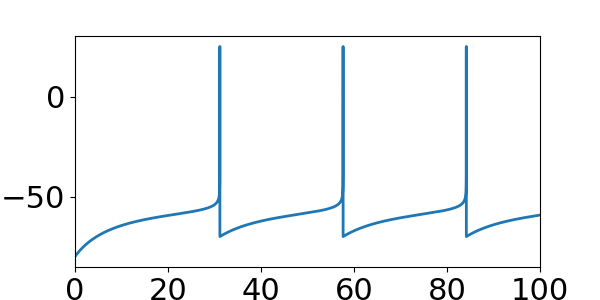

Text(0, 0.5, 'membrane potential (mv)')

In [7]:
%matplotlib notebook
glu_input  = 0.8
gaba_input = 0

Neuron.V[0] = -80
(V,Spike) = run(Neuron, glu_input, gaba_input); 
plt.figure(figsize=(6,3))
plt.plot(timearray, V, linewidth=2)
plt.xlim((0, 100))
plt.xlabel('time (ms)')
plt.ylabel('membrane potential (mv)')
#plt.savefig('EXP_KIR_Example.svg')

<IPython.core.display.Javascript object>


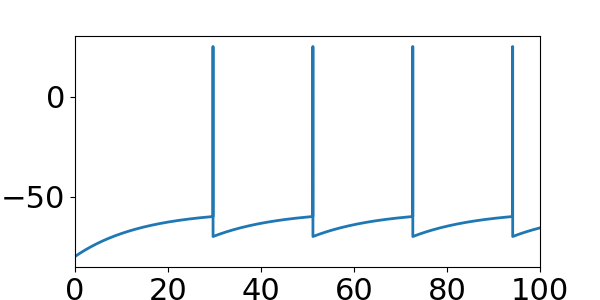

In [8]:
%matplotlib notebook
glu_input  = 0.4
gaba_input = 0

Neuron.V[0] = -80
(V,Spike) = run_LIF(Neuron, glu_input, gaba_input); 
plt.figure(figsize=(6,3))
plt.plot(timearray, V, linewidth=2)
plt.xlim((0, 100))
plt.xlabel('time (ms)')
plt.ylabel('membrane potential (mv)')
plt.savefig('LIF_Example.svg')

In [161]:
vi_list = np.linspace(-61, -56, 11)
gi_list = np.linspace(0,10,200)
firing_rate = np.zeros((len(vi_list), len(gi_list)))


for ind1,vi in tqdm(enumerate(vi_list)):
    
    Neuron.v_I[0] = vi

    for ind2,gi in enumerate(gi_list):
        Neuron.V[0] = -70
        firing_rate[ind1, ind2] = frate(Neuron, glu_input=0.8, gaba_input=gi)

KeyboardInterrupt: 

<IPython.core.display.Javascript object>


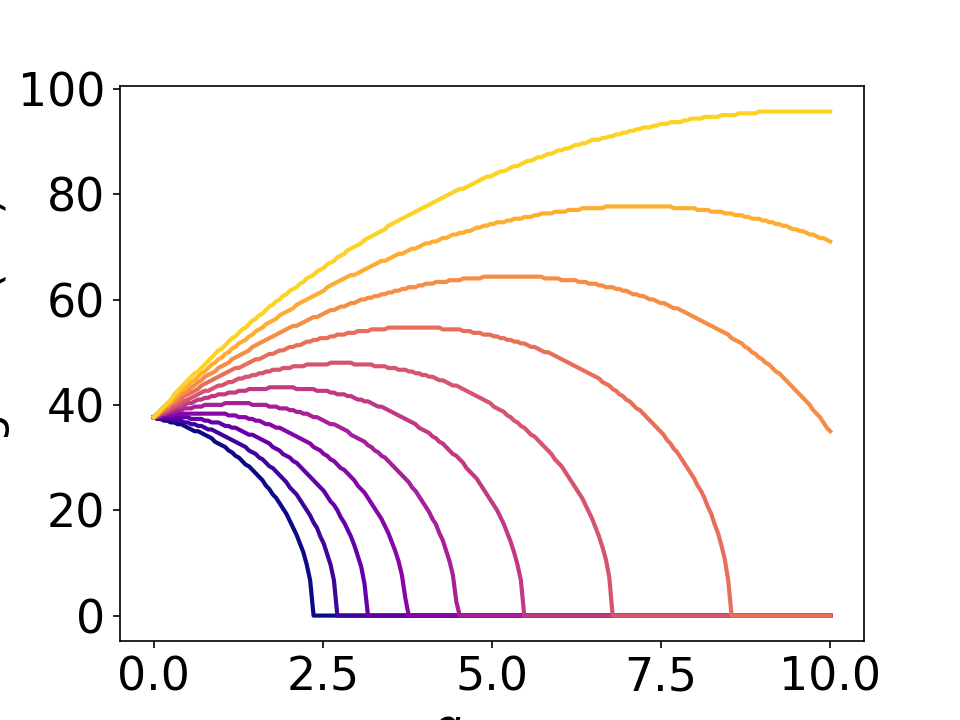

<IPython.core.display.Javascript object>


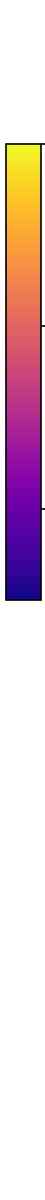

In [115]:
Vfig = plt.figure()


cmap = mpl.cm.get_cmap('plasma') 
color_list = [cmap(i/len(vi_list)) for i in range(len(vi_list))]

for ind1,vi in enumerate(vi_list):
    
        
    plt.plot(gi_list, firing_rate[ind1,:], label=str(vi-(-60)), color=color_list[ind1], linewidth=2)
    
plt.ylabel(r'firing rate (Hz)')
plt.xlabel(r'$g_{GABA}$');

plt.savefig('f_vs_gaba_exp_kir_model.svg')

fig, ax = plt.subplots(figsize=(0.3, 8))
fig.subplots_adjust(bottom=0.5)

cmap = mpl.cm.plasma
norm = mpl.colors.Normalize(vmin=vi_list[0]+60, vmax=vi_list[-1]+60)

cb1 = mpl.colorbar.ColorbarBase(ax, cmap=cmap,
                                norm=norm,
                                orientation='vertical')
cb1.set_label(r'$v_{\rm GABA}-v_{\rm T}$ (mV)')
fig.show()
plt.savefig('f_vs_gaba_colorbar_exp_model.svg')

## sub-threshold and supra-threshold dynamics

### using g

In [21]:
#LIF KIR EXP model

ge_list = np.linspace(0,1,50)
firing_rate = np.zeros(len(ge_list))
mem_potential = np.zeros(len(ge_list))

for ind1,ge in tqdm(enumerate(ge_list)):
    
    Neuron.V[0] = -70
    (V,Spike) = run(Neuron, glu_input=ge, gaba_input=0)
    rate = np.sum(Spike)/time*1000 
    firing_rate[ind1] = rate
    mem_potential[ind1] = V[-1]

In [23]:
# LIF model

ge_list = np.linspace(0,1,50)
firing_rate = np.zeros(len(ge_list))
mem_potential = np.zeros(len(ge_list))

for ind1,ge in tqdm(enumerate(ge_list)):
    
    Neuron.V[0] = -70
    (V,Spike) = run_LIF(Neuron, glu_input=ge, gaba_input=0)
    rate = np.sum(Spike)/time*1000 
    firing_rate[ind1] = rate
    mem_potential[ind1] = V[-1]

<IPython.core.display.Javascript object>


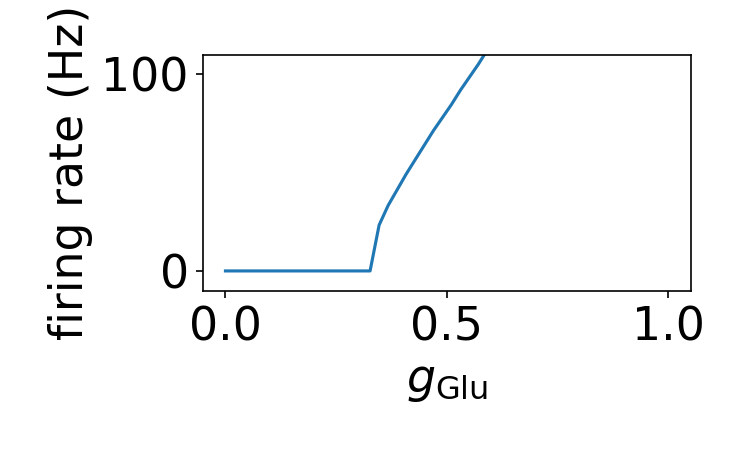

<IPython.core.display.Javascript object>


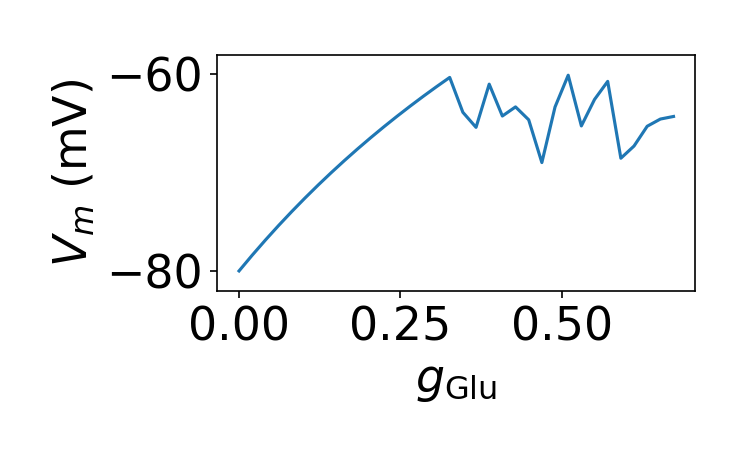

In [24]:
plt.figure(figsize=(5,3))
plt.plot(ge_list, firing_rate)
plt.ylabel(r'firing rate (Hz)')
plt.xlabel(r'$g_{\rm Glu}$')
plt.ylim([-10, 110])
plt.tight_layout();

#plt.savefig('suprathreshold_exp_kir_model.svg')
plt.savefig('suprathreshold_lif_model.svg')


plt.figure(figsize=(5,3))
plt.plot(ge_list[0:34], mem_potential[0:34])
plt.ylabel(r'$V_m$ (mV)')
plt.xlabel(r'$g_{\rm Glu}$')
plt.ylim([-82, -58])
plt.tight_layout();


#plt.savefig('subthreshold_exp_kir_model.svg')
plt.savefig('subthreshold_lif_model.svg')

### using I

In [22]:
#LIF KIR EXP model

I_list = np.linspace(-2000,500,50)
#I_list = np.linspace(0,400,50)
firing_rate_1 = np.zeros(len(I_list))
mem_potential_1 = np.zeros(len(I_list))

for ind1,I in tqdm(enumerate(I_list)):
    
    Neuron.V[0] = -70
    (V,Spike) = run(Neuron, glu_input=0, gaba_input=0, gl=5, I=I)
    rate = np.sum(Spike)/time*1000 
    firing_rate_1[ind1] = rate
    mem_potential_1[ind1] = V[-1]

In [21]:
# LIF model

I_list = np.linspace(-2000,500,50)
#I_list = np.linspace(0,400,50)
firing_rate_2 = np.zeros(len(I_list))
mem_potential_2 = np.zeros(len(I_list))

for ind1,I in tqdm(enumerate(I_list)):
    
    Neuron.V[0] = -70
    (V,Spike) = run_LIF(Neuron, glu_input=0, gaba_input=0, I=I)
    rate = np.sum(Spike)/time*1000 
    firing_rate_2[ind1] = rate
    mem_potential_2[ind1] = V[-1]

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1241: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


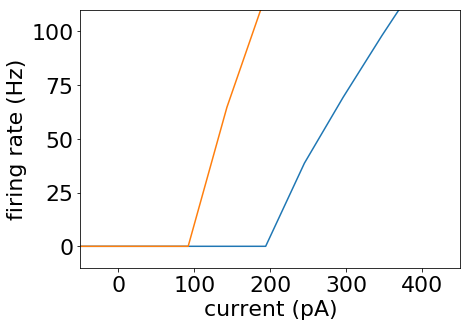

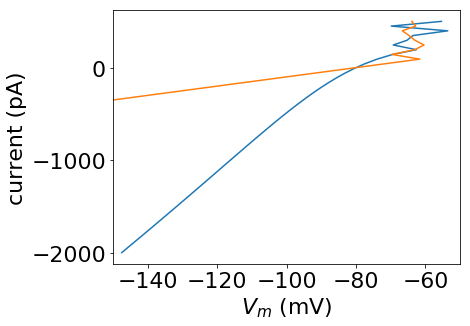

In [23]:
plt.figure(figsize=(7,5))
plt.plot(I_list, firing_rate_1)
plt.plot(I_list, firing_rate_2)
plt.ylabel(r'firing rate (Hz)')
plt.xlabel(r'current (pA)')
plt.ylim([-10, 110])
plt.xlim([-50, 450])
plt.tight_layout();

#plt.savefig('suprathreshold_both_model.svg')
#plt.savefig('suprathreshold_exp_kir_model.svg')
#plt.savefig('suprathreshold_lif_model.svg')


plt.figure(figsize=(7,5))
plt.plot(mem_potential_1[0:], I_list[0:])
plt.plot(mem_potential_2[0:], I_list[0:])
plt.xlabel(r'$V_m$ (mV)')
plt.ylabel(r'current (pA)')
plt.xlim([-150, -50])
plt.tight_layout();

plt.savefig('subthreshold_both_model.svg')
#plt.savefig('subthreshold_exp_kir_model.svg')
#plt.savefig('subthreshold_lif_model.svg')

## effect of EXP current on non-monoticity

In [45]:
Neuron.v_I[0] = -60
delta_list = np.linspace(1, 10, 10)
gi_list = np.linspace(0,4,200)
firing_rate = np.zeros((len(delta_list), len(gi_list)))


for ind1,delta in tqdm(enumerate(delta_list)):
    
    Neuron.Delta_t[0] = delta

    for ind2,gi in enumerate(gi_list):
        Neuron.V[0] = -70
        firing_rate[ind1, ind2] = frate(Neuron, glu_input=0.8, gaba_input=gi)

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


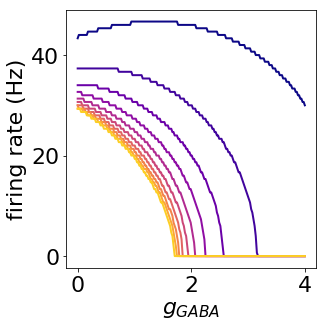

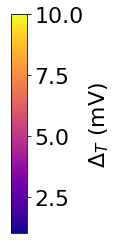

In [47]:
Vfig = plt.figure(figsize=(5,5))



cmap = mpl.cm.get_cmap('plasma') 
color_list = [cmap(i/len(delta_list)) for i in range(len(delta_list))]

for ind1,delta in enumerate(delta_list):
    
        
    plt.plot(gi_list, firing_rate[ind1,:], label=str(delta), color=color_list[ind1], linewidth=2)
    
plt.ylabel(r'firing rate (Hz)')
plt.xlabel(r'$g_{GABA}$');
plt.tight_layout()
#plt.xlim((-0.2,5.2))

plt.savefig('f_vs_gaba_exp_kir_model_DeltaEffect_vgaba-60.svg')

fig, ax = plt.subplots(figsize=(0.3, 8))
fig.subplots_adjust(bottom=0.5)

cmap = mpl.cm.plasma
norm = mpl.colors.Normalize(vmin=delta_list[0], vmax=delta_list[-1])

cb1 = mpl.colorbar.ColorbarBase(ax, cmap=cmap,
                                norm=norm,
                                orientation='vertical')
cb1.set_label(r'$\Delta_T$ (mV)')
fig.show()
#plt.savefig('f_vs_gaba_colorbar_exp_model_Delta.svg')